In [1]:
import yt
import numpy as np
import h5py
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import mpl_toolkits.mplot3d.axes3d as p3

yt.funcs.mylog.setLevel(50)

plt.rcParams["animation.html"] = "jshtml"
#unit_base = {'UnitLength_in_cm' : 1, 'UnitMass_in_g' : 1,  'UnitVelocity_in_cm_per_s' : 1} 
unit_base = {'UnitLength_in_cm': 1.496e13, 'UnitMass_in_g': 1.989e33, 'UnitVelocity_in_cm_per_s' : 474318.3259}

bbox_lim = 80      # in unit_base length
bbox = [[-bbox_lim,bbox_lim], [-bbox_lim,bbox_lim],  [-bbox_lim,bbox_lim]]
#ts = yt.load("/u/yali/gDisk0/test/output/snapshot_00*.hdf5",unit_base=unit_base, bounding_box=bbox)
ts = yt.load("/u/yali/gDisk1/test/output/snapshot_0*.hdf5",unit_base=unit_base, bounding_box=bbox)
ts0 = ts[0]
ds = ts0.all_data()
#ts.derived_field_list
#f = h5py.File("/u/yali/gDisk3/test/output/snapshot_000.hdf5", "r") # Read-only access to the file

In [2]:
print ("Length unit: ", ts0.length_unit.in_units('code_length'))
print ("Length unit: ", ts0.length_unit.in_units('AU'))
print ("Time unit: ", ts0.time_unit.in_units('code_time'))
print ("Time unit: ", ts0.time_unit.in_units('yr'))
print ("Mass unit: ", ts0.mass_unit.in_units('code_mass'))
print ("Mass unit: ", ts0.mass_unit.in_units('Msun'))
print ("Velocity unit: ", ts0.velocity_unit.in_units('code_velocity'))
print ('left edge: ',ts0.domain_left_edge)
print ('right edge: ',ts0.domain_right_edge)
print ('center: ',ts0.domain_center)
center = ts0.arr([50,50,50], 'code_length')
print(center.in_units("AU"))
print(ts0.length_unit.in_units('AU'))
print(ts0.length_unit.in_units('cm'))

Length unit:  0.9999999999999998 code_length
Length unit:  1.0000142331519999 AU
Time unit:  1.0 code_time
Time unit:  0.9994422897288967 yr
Mass unit:  1.0 code_mass
Mass unit:  1.0002937715453548 Msun
Velocity unit:  1.0 code_velocity
left edge:  [-80. -80. -80.] code_length
right edge:  [80. 80. 80.] code_length
center:  [0. 0. 0.] code_length
[50.00071166 50.00071166 50.00071166] AU
1.0000142331519999 AU
14959999999999.998 cm


In [ ]:
# calculate averaged quantity
average_value = ds.quantities.weighted_average_quantity("temperature", "cell_mass")#(field, weight)

# calculate summed quantity in an yt object, here sp = sphere
baryon_mass, particle_mass = sp.quantities.total_quantity(["cell_mass", "particle_mass"])

[34.58973694 34.76397324 34.70589447 ... 34.6478157  34.6478157
 34.76397324] code_length
[5.18329595 5.21284924 5.20294209 ... 5.19309111 5.19309111 5.21284924] K


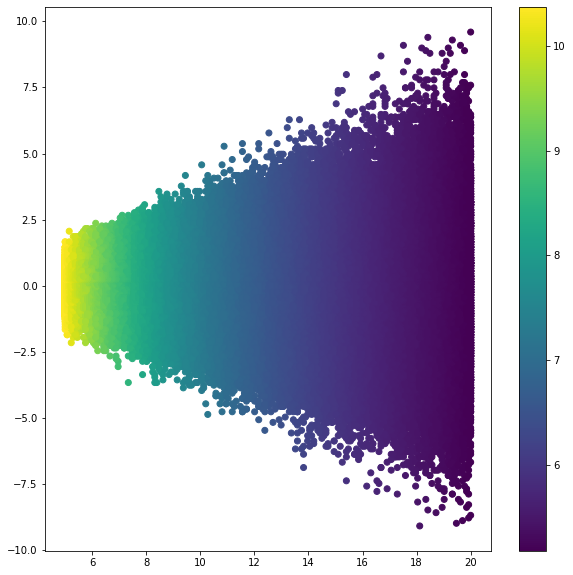

In [55]:
from yt.units import G, kboltz
coordx = ds[('PartType0', 'particle_position_x')];  coordy = ds[('PartType0', 'particle_position_y')]; coordz = ds[('PartType0', 'particle_position_z')]
temp = ts0.all_data()[('PartType0', 'temperature')]
print(coordx)
#def _pressure(field, data):
#    return (data.ds.gamma - 1.0) * data["density"] * data["thermal_energy"]
#yt.add_field(("gas", "pressure"), function=_pressure, units="dyne/cm**2")
def _rad(data):
    return ((data[('PartType0', 'particle_position_x')] - center[0])**2+(data[('PartType0', 'particle_position_y')] -center[1])**2)**0.5
def _height(data):
    return data[('PartType0', 'particle_position_z')] - center[2]
rad = _rad(ds); height = _height(ds)
gamma_eos = 5./3.           # polytropic index of ideal equation of state the run will assume   # defined in Config.sh
kboltz = kboltz.in_units("AU**2 * Msun * yr**-2 * K**-1")
mu = 2.3;   proton_mass = ts0.arr(1.6726219e-27, 'kg').in_units('Msun');    mean_molecular_weight = mu*proton_mass
M_star = ts0.arr(1, 'Msun')
G = G.in_units("AU**3 * Msun**-1 * yr**-2")

def c_s(r):                 # speed of sound
    return (kboltz * temp/mean_molecular_weight)**0.5     
def Omega_K(r):             # Keplerian angular speed
    return (G*M_star/r**3)**0.5 
def vertical_scale_h(r):
    return c_s(r) / Omega_K(r)
def AspectRatio(r):         # for verification: representative value = 0.05
    return vertical_scale_h(r)/r
#def Q(r):                   # for verification
#    return c_s(r)*Omega_K(r)/(np.pi*G*Sigma(r))
print(temp)
import matplotlib.pyplot as plt
plt.figure(figsize = (10, 10))
plt.scatter(rad, height, c = temp)
plt.colorbar()
#plt.scatter(rad, AspectRatio(rad))

## Animation

In [83]:
plot = yt.ParticlePlot(ts[0], ('PartType0', 'particle_position_x'), ('PartType0','particle_position_y'), ('PartType0', 'temperature'), center = center, width = center*2)

# Modify the projection, The argument specifies the region along the line of sight for which particles will be gathered.
# p.annotate_particles(1.0) # 1.0 signifies the entire domain in the line of sight
#plot.annotate_grids()
#plot.show()

fig = plot.plots[('PartType0', 'temperature')].figure

def animate(i):
    ds = ts[i]
    plot._switch_ds(ds)
    plot.annotate_timestamp(corner='upper_left', redshift=False, draw_inset_box=True)
    plot.annotate_scale(corner='upper_right')
    
plot.set_buff_size((800, 800))
ani = FuncAnimation(fig, animate, frames=10)#len(ts))
ani

/u/yali/anaconda3/lib/python3.7/site-packages/yt/units/yt_array.py:978: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  ret = super(YTArray, self).__getitem__(item)
/u/yali/anaconda3/lib/python3.7/site-packages/yt/fields/fluid_fields.py:201: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_field[slice_3d] = f
/u/yali/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


In [46]:
#plot = yt.ParticlePlot(ts0,  'particle_position_x', 'particle_position_y', ('PartType0', 'InternalEnergy'), center = center, width = center)
plot = yt.ParticlePlot(ts0,  'particle_position_cylindrical_radius', 'particle_position_cylindrical_z', ('PartType0', 'Temperature'))#, center = center, width = center)
# equivalent to yt.ParticleProjectionPlot(ts0, 'z', fields = ("PartType0", "Temperature"),center = center, width = center)
#plot.annotate_velocity(factor = 50)  # Draw a velocity vector every 50 pixels.
#plot.set_unit('density', 'Msun/AU**3')
plot

TypeError: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.

## Radial profile

In [103]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
#ax = plt.axes(xlim=(size1,size2),ylim=(size1, size2))
#dens_plot = ax.loglog(rp.x.value, rp["density"].value)
dens_plot, = ax.plot([],[], linestyle = "--", linewidth = 3, color = "b", marker = "x", markersize = 8)
ax.set_xlabel(r"$\mathrm{r^2 \Omega}$")#r"$\mathrm{r\ (AU)}$")
ax.set_ylabel(r"$\mathrm{\rho\ (g\ cm^{-3})}$")
ax.set_xlim([0, 30])
#ax.set_yscale("log")
ax.set_ylim([0, 100])
#fig.savefig("density_profile_default.png" % ds)
    
def update(i):
    cur = ts[i]
    #disk = cur.sphere([50,50,50], (50, "kpc"))
    # Get a disk object: center, normal, radius, height, fields=None, ds=None, field_parameters=None, data_source=None
    disk = cur.disk(ts0.arr([50,50,50], 'code_length'), [0,0,1], (50., "AU"), (20., "AU")) 
    # objects can be combined
    #new_obj = sp1 + sp2, cutout = sp1 - sp3, sp4 = sp1 ^ sp2, sp5 = sp1 & sp2
    # Bin up the data from the disk into a radial profile
    rp = yt.create_profile(disk, 'radius', [('gas', 'density'), ('gas', 'temperature'), ('gas', 'angular_momentum_magnitude')],
                            n_bins = 128,
                            units = {'radius': 'AU'},
                            logs = {'radius': False})
    dens_plot.set_data(rp.x.value, rp["temperature"].value)
    #intE.append(f['PartType0']['InternalEnergy'][:])
    return dens_plot,
plt.close()
ani = FuncAnimation(fig, update, 8, blit=True)
ani

/u/yali/anaconda3/lib/python3.7/site-packages/yt/units/yt_array.py:978: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  ret = super(YTArray, self).__getitem__(item)
/u/yali/anaconda3/lib/python3.7/site-packages/yt/fields/fluid_fields.py:201: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_field[slice_3d] = f
